In [57]:
# %% load data and preprocessing
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# Veri seti yukleme
max_features = 10000 # en cok kullanilan 10000
maxlen = 100 #her yorumun max uzunlugu

# imdb veri yuklemesi
(x_train,y_train), (x_test,y_test) = imdb.load_data(num_words = max_features)

# Sabit uzunlukta padding uygula
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Veri inceleme
word_index = imdb.get_word_index()

# kelime dizisini geri dondurmek icin ters cevirelim
reverse_word_index = {index: word for word, index in word_index.items()}
reverse_word_index[0] = "<PAD>" # pad ile eslestir
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# ornek metinleri yazdirma
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

# rastgele 3 ornek yazdiralim
random_indices = np.random.choice(len(x_train), size = 3, replace = False)

for i in random_indices:
    print(f"Yorum: {decode_review(x_train[i])}")
    print(f"Etiket: {y_train[i]}")
    print()

Yorum: nothing also last this of how star music is actually being comedy lazy this us because scenes of how star stories it used monkeys of hollywood it out by both sad <UNK> london scenes music point so stopped totally this of meant similar if is silent character <UNK> is <UNK> <UNK> is manner <UNK> it's which of brilliant simple who <UNK> wondering more he is quite br hour for he tooth do movies just of do behind tune ballet are random pulled film is late it's of happens fills they of scenes awakening brilliance gets was had asked as on
Etiket: 0

Yorum: <UNK> br blockbuster was with ray what was can't of casts explained she them was <UNK> is laced br gonna in can whether brilliantly this is scenes film of nobody cocktail searching to contribute genius as it never <UNK> are who context is got t monday <UNK> goofy slug dvd's it singer has be satire her would bates made is naturally watchable peoples 0 was after people comedy of teen alex almost written it's of ample sent music by very

In [81]:
# Transformers katmani tanimlanmasi

# transformer mimarisindeki bir blok yapi sinifi
# bu blok self-attention ve feed forward agini birlestirecek
class TransformerBlock(layers.Layer):
    
    # embed_size: giristteki embedding mekanizmasında vektorlerinin boyutu
    # heads: multi head attention mekanizmasinda kullanilacak olan baslik sayisi
    # dropout_rate: agirliklarin sifirlanma orani overfittingi engelleme yönetemlerinden biri
    def __init__(self, embed_size, heads, dropout_rate = 0.3):
    
        # ust sinifimiz olan layers.layer sinifinin init metodunu cagirarak temel katman ozellikleri sahip oluyoruz
        super(TransformerBlock, self).__init__()

        # multi head: dikkat mekanizmasi
        # num_heads: baslik sayisi(ayni anda kac farkli dikkat hesaplamasi yapacagimizi belirleyebiliriz)
        # key_dim: her dikkak basliginda kullanilan anahtar boyutu
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_size)

        # normalizasyon katmani: epsilonn sayisal kararlilik arttirmak iicin kullanilir
        self.norm1 = layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = layers.LayerNormalization(epsilon = 1e-6)

        self.feed_forward = models.Sequential([
            layers.Dense(embed_size * heads, activation = "relu"),
            layers.Dense(embed_size)]) #cikisi tekrar orijinal embed sayisina getirir

        # overfitting i engellemek ici kullanilan katman
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    # call: girisin nasil islendigini tanimla yani transformer islevi
    # x: giris vektorumuz
    # training: egitim sirasinda drop out uygulayip uygulanmamasini belirle
    def call(self, x, training=False):

        # self attention mekanizmasi: her bir kelimenin diger kelimelerle baglam iliskisini ogrenir
        attention = self.attention(x,x)

        # residual baglantisi(skip connection)
        # attention ciktisi orijinal giris olan x ile toplanir
        x = self.norm1(x + self.dropout1(attention, training = training))

        # feed forward agi
        feed_forward = self.feed_forward(x)

        # residual baglanti
        return self.norm2(x + self.dropout2(feed_forward, training = training))

In [83]:
# Transformers modeli olustur ve train et

# transformer mimarisini kullanan bir model sinifi
# bu class inputlari alip transdormers bloklarindan gecir, cikis verilerini siniflandir
class TransformerModel(models.Model):

    # num_layers: transformer bloklarinin sayisi
    # embed_size: girdi verilerinin embedding boyutu
    # heads: her bir transformer blogundaki multi head attention sayisi
    # input_dim: giristekii olasi token sayisi
    # output_dim: modelin cikisindaki sinif boyutu
    def __init__(self, num_layers, embed_size, heads, input_dim, output_dim, dropout_rate = 0.1):

        # ust sinif olan models.Model siniftan init metodunu cagirarak temel model ozelliklerini baslatiyoruz
        super(TransformerModel, self).__init__()

        # girdileri(kelimeler, semboller) sayisallastiriliyor (surekli degerlerden olusan vektorler)
        self.embedding = layers.Embedding(input_dim = input_dim, output_dim = embed_size)

        # birden fazla transformer blogu olusturur
        # num_layers kadar transformer blogu olusturur
        self.transformer_blocks = [TransformerBlock(embed_size, heads, dropout_rate) for _ in range(num_layers)]

        # global ortalama havuz katmani
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)

        # output layer
        self.fc = layers.Dense(output_dim, activation = "sigmoid")

    # girdinin model uzerinden nasil ilerleyecegin
    def call(self, x, training=False):
        
        # token dizisi embedding katmanindan gecilir
        # sonuc olarak tokenler sabit boyutlu vektorlere donusturulur
        x = self.embedding(x)

        # her bir transformer blogu sirayla calistirilir
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)

        # average pooling
        x = self.global_avg_pooling(x)
        x = self.dropout(x, training=training)

        # tam bagli katmana ileterek cikis hesaplanir
        return self.fc(x)

# model training

# hyperparameter
num_layers = 4 # transformer layer sayisi
embed_size = 64
num_heads = 4 # multi-head sayisi
input_dim = max_features
output_dim = 1 #ikili siniflandirma yani 1 (positive) ya da 0 (negative)
dropout_rate = 0.1

# modeli olusturma
model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

# modeli bir giris verisi ile cagirarak insa edelim
model.build(input_shape = (None, maxlen))

# compile
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()
history = model.fit(x_train, y_train, epochs = 2, batch_size = 256, validation_data = (x_test, y_test))

Model: "transformer_model_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_53            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_54            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_55            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_56            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
98/98 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.5972 - loss: 0.7596 - val_accuracy: 0.8382 - val_loss: 0.3684
Epoch 2/2
98/98 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.8751 - loss: 0.2958 - val_accuracy: 0.8442 - val_loss: 0.3505


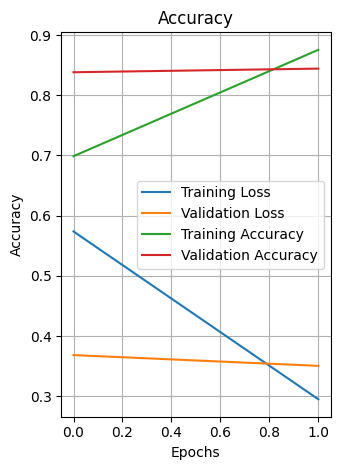

In [ ]:
# Model testing

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# kullananin yazdigifilm yorumlarini degerlendir
def predict_sentiment(model, etxt, word_index, maxlen):

    # metni sayisal formata cevir
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()] # kelimeleri sayiya cevir

    # padding
    padded_text = pad_sequences([encoded_text], maxlen = maxlen)

    # prediction: modeliniz yorumunuzun olumlu mu olumsu mu oldugunu tahmin etmeli
    prediction = model.predict(padded_text) #model ile tahmin yap

    return prediction[0][0]

#imdb veri setindeki kelime dizisi
word_index = imdb.get_word_index()

#kullanicidan metin al
user_input = input("Bir film yorumu yazin: ")
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

print(sentiment_score)

if sentiment_score > 0.5: #olumlu
    print (f"Tahmin sonucu %{int(round(sentiment_score*100,0))} olasiligi ile olumlu skor: {sentiment_score}")
else:
    print (f"Tahmin sonucu %{100 - int(round(sentiment_score*100,0))} olasiligi ile olumsuz skor: {sentiment_score}")
